In [1]:
import os, zipfile, warnings
import numpy as np
import pandas as pd

RANDOM_STATE = 42

In [2]:
import easydict
args = easydict.EasyDict()

args.default_data_path = './data/'

args.train_csv = args.default_data_path + 'aug_train.csv'
args.test_csv = args.default_data_path + 'aug_test.csv'


In [3]:
df = pd.read_csv(args.train_csv)
ori_test = pd.read_csv(args.test_csv)

In [4]:
df.shape, ori_test.shape

((19158, 14), (2129, 13))

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

4) experience 수치화 & 관심 변수 전처리
- experience: "<1"→0, "1"~"20"→int, ">20"→21 (또는 20으로 묶어도 됨)
- relevent_experience: Has relevent experience → 1, else 0
- major_discipline: STEM 여부 → 1/0 (원본은 카테고리로도 유지함)

In [6]:
# -----------------------------
# 4) experience 수치화 & 관심 변수 전처리
#    - experience: "<1"→0, "1"~"20"→int, ">20"→21 (또는 20으로 묶어도 됨)
#    - relevent_experience: Has relevent experience → 1, else 0
#    - major_discipline: STEM 여부 → 1/0 (원본은 카테고리로도 유지함)
# -----------------------------
def to_experience_num(x):
    if pd.isna(x): return np.nan
    s = str(x).strip()
    if s == "<1": return 0
    if s.startswith(">"):
        try: return float(s[1:]) + 1  # >20 -> 21
        except: return 21
    try: return float(s)
    except: return np.nan

df["experience_num"] = df["experience"].apply(to_experience_num) if "experience" in df.columns else np.nan
df["rel_exp_flag"]   = (df["relevent_experience"] == "Has relevent experience").astype(int) if "relevent_experience" in df.columns else 0
df["stem_flag"]      = (df["major_discipline"] == "STEM").astype(int) if "major_discipline" in df.columns else 0

# -----------------------------
# 5) 파생 피처 생성 (실험 포인트)
# -----------------------------
df["rel_exp_score"] = df["experience_num"].fillna(0) * df["rel_exp_flag"]   # 경력×관련경험
df["stem_related"]  = df["stem_flag"] * df["rel_exp_flag"]                  # STEM×관련경험

# 경험 구간화 (0–2, 3–5, 6–9, 10–14, 15+)
exp_bins   = [-1, 2, 5, 9, 14, 100]
exp_labels = ["exp_0_2", "exp_3_5", "exp_6_9", "exp_10_14", "exp_15p"]
if "experience_num" in df.columns:
    df["exp_bin"] = pd.cut(df["experience_num"], bins=exp_bins, labels=exp_labels)

# 전공×관련경험 조합 카테고리
def major_relexp_group(row):
    m = row.get("major_discipline", np.nan)
    r = row.get("relevent_experience", np.nan)
    if pd.isna(m) or pd.isna(r): return "UNK"
    m2 = "STEM" if m=="STEM" else "NonSTEM"
    r2 = "Rel" if r=="Has relevent experience" else "NoRel"
    return f"{m2}_{r2}"
df["major_relexp_grp"] = df.apply(major_relexp_group, axis=1)

In [7]:
# -----------------------------
# 4) experience 수치화 & 관심 변수 전처리
# -----------------------------
def to_experience_num(x):
    if pd.isna(x): 
        return np.nan
    s = str(x).strip()
    if s == "<1": 
        return 0
    if s.startswith(">"):
        try: 
            return float(s[1:]) + 1   # >20 -> 21
        except: 
            return 21
    try: 
        return float(s)
    except: 
        return np.nan

df["experience_num"] = df["experience"].apply(to_experience_num) if "experience" in df.columns else np.nan
df["rel_exp_flag"]   = (df["relevent_experience"] == "Has relevent experience").astype(int) if "relevent_experience" in df.columns else 0
df["stem_flag"]      = (df["major_discipline"] == "STEM").astype(int) if "major_discipline" in df.columns else 0

# -----------------------------
# 5) 파생 피처 생성 (숫자형 변환 포함)
# -----------------------------
df["rel_exp_score"] = df["experience_num"].fillna(0) * df["rel_exp_flag"]
df["stem_related"]  = df["stem_flag"] * df["rel_exp_flag"]

# 경험 구간화 후 → 원핫인코딩/숫자화
exp_bins   = [-1, 2, 5, 9, 14, 100]
exp_labels = ["exp_0_2", "exp_3_5", "exp_6_9", "exp_10_14", "exp_15p"]
if "experience_num" in df.columns:
    df["exp_bin"] = pd.cut(df["experience_num"], bins=exp_bins, labels=exp_labels)
    # 숫자형 코드로 변환
    df["exp_bin_code"] = df["exp_bin"].cat.codes  # -1은 NaN을 의미

# 전공×관련경험 조합 카테고리 → 숫자형 코드
def major_relexp_group(row):
    m = row.get("major_discipline", np.nan)
    r = row.get("relevent_experience", np.nan)
    if pd.isna(m) or pd.isna(r): return "UNK"
    m2 = "STEM" if m=="STEM" else "NonSTEM"
    r2 = "Rel" if r=="Has relevent experience" else "NoRel"
    return f"{m2}_{r2}"

df["major_relexp_grp"] = df.apply(major_relexp_group, axis=1)
df["major_relexp_code"] = df["major_relexp_grp"].astype("category").cat.codes


- experience_num: 경력(0~21, float)

- rel_exp_flag: 관련 경험 여부 (0/1)

- stem_flag: STEM 여부 (0/1)

- rel_exp_score: 경력×관련경험 (float)

- stem_related: STEM×관련경험 (0/1)

- exp_bin_code: 경험 구간화 결과 (정수 코드, -1은 NaN)

- major_relexp_code: 전공×관련경험 조합 (정수 코드)

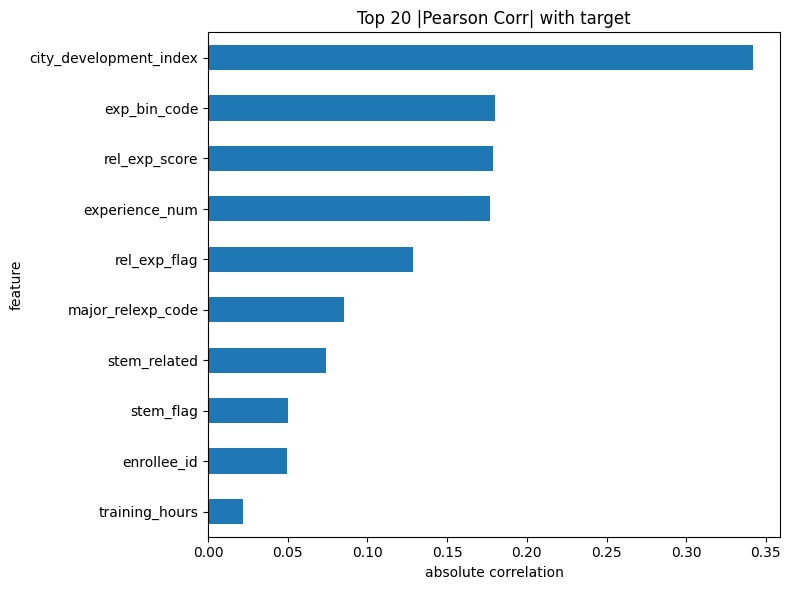

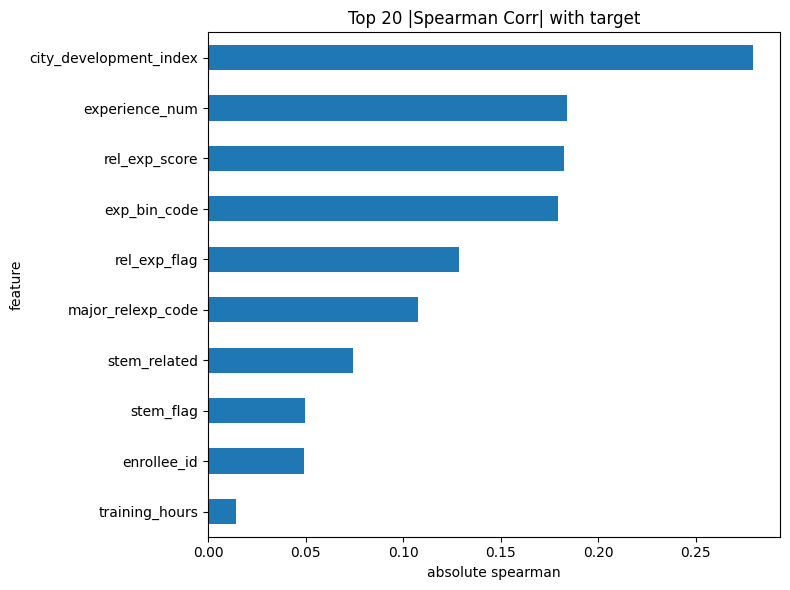

ValueError: Input X contains NaN.

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import MinMaxScaler

assert 'target' in df.columns, "ori_train에 binary target 컬럼이 필요합니다."

# 숫자 피처만 추출 (target 제외)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c != 'target']

X = df[num_cols].copy()
y = df['target'].astype(int).values

# 상수(분산 0) 피처 제거
const_cols = X.columns[X.nunique(dropna=False) <= 1]
if len(const_cols):
    X = X.drop(columns=const_cols)
    num_cols = [c for c in num_cols if c not in const_cols]

topn = 20  # 상위 몇 개 보여줄지

# 1) Pearson 상관(절대값)
corr_abs = df[num_cols + ['target']].corr(numeric_only=True)['target'] \
            .drop('target').abs().sort_values(ascending=False)

plt.figure(figsize=(8, 6))
corr_abs.head(topn).iloc[::-1].plot(kind='barh')
plt.title(f"Top {topn} |Pearson Corr| with target")
plt.xlabel("absolute correlation")
plt.ylabel("feature")
plt.tight_layout()
plt.show()

# 2) Spearman 상관(절대값)
spearman_abs = df[num_cols + ['target']].corr(method='spearman', numeric_only=True)['target'] \
               .drop('target').abs().sort_values(ascending=False)

plt.figure(figsize=(8, 6))
spearman_abs.head(topn).iloc[::-1].plot(kind='barh')
plt.title(f"Top {topn} |Spearman Corr| with target")
plt.xlabel("absolute spearman")
plt.ylabel("feature")
plt.tight_layout()
plt.show()

# 3) Mutual Information (비선형 관계도 반영)
X_scaled = MinMaxScaler().fit_transform(X)  # 안정화를 위해 0~1 스케일
mi_vals = mutual_info_classif(X_scaled, y, discrete_features=False, random_state=42)
mi_s = pd.Series(mi_vals, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8, 6))
mi_s.head(topn).iloc[::-1].plot(kind='barh')
plt.title(f"Top {topn} Mutual Information w/ target")
plt.xlabel("mutual information")
plt.ylabel("feature")
plt.tight_layout()
plt.show()